# Propagation of coupled translational-rotational dynamics

## Disclaimer
The presented code requires the developer versions of tudat and tudatpy. Check whether your tudat-space environment fulfills this condition by opening a terminal, activating the envrionment with `conda activate tudat-space` and then running `conda list | grep dev`. If there is no output to this command, you don't have the developer versions of tudat and tudatpy. Check [this documentation](https://docs.tudat.space/en/latest/_src_getting_started/installation.html) for instructions on how to acquire these versions.

## Context
The present example will demonstrate the use of a multi-type propagator in Tudat. For that, we will consider the problem of simulating the coupled translational-rotational dynamics of Phobos around Mars. Let's begin by talking about the forces and torques that ww'll be considering as part of our dynamical problem.

## Phobos' dynamics in the Martian system
A complete description of the state vector and the equations of motion can be found in [reference to sections 2.4.1 and 2.4.2 of my literature study], with a derivation of the equations in the preceding sections and chapters. However, it is useful to write down Newon's second law of translation and rotational motion here, and include in the process all the accelerations and torques that we will model in this example. These two equations read as follow:

\begin{equation}
\frac{\text{d}\vec v}{\text{d}t}=(\mu_{\text{M}}+\mu_{\text{P}}) \left(-\frac{\vec r}{r^3}+\frac{1}{\mu_{\text{M}}}\mathbf{R^{\mathcal{I/M}}}\nabla_{\mathcal M}U_{\text{M}}(\vec\rho_M^{\ P}) - \frac{1}{\mu_{\text{P}}}\mathbf{R^{\mathcal{I/P}}}\nabla_{\mathcal P}U_{\text{P}}(\vec\rho_P^{\ M})\right) - \sum_{i=1}^N\mu_i\left(\frac{\vec r_{iP}}{r_{iP}^3}-\frac{\vec r_i}{r_i^3}\right)
\end{equation}
\begin{equation}
    \mathbf I\frac{\text d\vec\omega}{\text dt} + \vec\omega\times\left(\mathbf I\vec\omega\right) = -M\vec\rho_P^{\ M}\times\left(\mathbf{R^{\mathcal{I/P}}}\nabla_{\mathcal P}U_{\text{P}}(\vec\rho_P^{\ M})\right) - \sum_{i=1}^NM_i\vec\rho_P^{\ i}\times\left(\mathbf{R^{\mathcal{I/P}}}\nabla_{\mathcal P}U_{\text{P}}(\vec\rho_P^{\ i})\right)
\end{equation}

Here: \
· Subindices/superindices $P$, $M$ and $i$ refer to Phobos, Mars and the $i$-th third body. Superindex $I$ refers to an _inertial_ reference frame. \
· $\vec r_{AB}$ is a _position_ vector going from body A to body B. No subindices mean the vector goes from Mars to Phobos. \
· $\vec\rho_A^B$ is a vector going from A to B and expressed in the vector basis attached to the reference frame of body A. \
· $\vec v$ is the velocity vector of Phobos. \
· $\vec\omega$ is the angular velocity vector of Phobos, expressed in Phobos' reference frame. \
· $\mathbf I$ is the inertia tensor of Phobos. \
· $\mu_A$ is the gravitational parameter of body A. \
· $\mathbf{R^{\mathcal{A/B}}}$ is the rotation matrix from frame $\mathcal B$ to frame $\mathcal A$. \
· $\nabla_{\mathcal A}$ represents the gradient operator taken with respect to the coordinates associated to reference frame $\mathcal A$. \
· $U_A$ is the gravitational potential generated by body A, usually expanded in terms of spherical harmonic coefficients. \
· $M_A$ is the mass of body A.

As you can see, our example simulation will include the following accelerations/torques: \
· Mutual spherical harmonic acceleration between Mars and Phobos. Mars' gravity field will be expanded to D/O 10/10; we will use Phobos' quadrupole gravity field, i.e. including only the central term, and coefficients $C_{2,0}$ and $C_{2,2}$. \
· Third body forces will include those of the Sun, the Earth, Deimos and Jupiter. \
· The torque that the center of mass of Mars exerts on Phobos' quadrupole gravity field. \
· The torque exerted on Phobos' quadrupole gravity field by these bodies: the Sun, the Earth, Deimos and Jupiter (the same bodies as in the accelerations).

## Where is each term defined in Tudat?
When implementing the dynamics in tudat, it is always usefule to keep in mind the a-priori knowledge that we need in order to integrate the equations. In other words, what _environments_ we will have to define and/or use. In this case, the full state of Phobos will be propagated, so its position, velocity, orientation and angular velocity are **all** propagated states. As an example, in a simple translational propagation, the orientation and angular velocity are given by the **environment** through the body's _rotation model_. In this coupled propagation, the environment will have to define: \
· The gravity field of all bodies (either spherical harmonic gravity field or central gravity field). \
· A rotation model for Mars. \
· The _ephemeris_ of all third bodies. \
· The inertia tensor of Phobos.

For most of these, we will use the defaults provided by spice. Phobos, however, is very poorly implemented in Tudat. For this detailed of a propagation, we will have to create it ourselves from scratch.

## Import statements
As usual at the beginning of a script, we have the import statements. These are all the packages we will need for this example application. We include here the loading of the standard spice kernels.

In [1]:
# IMPORTS
import numpy as np
from numpy import pi as PI
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import polyfit
from tudatpy.util import result2array
from tudatpy.kernel.interface import spice
from tudatpy.kernel import constants, numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup, propagation_setup
from tudatpy.kernel.astro.element_conversion import rotation_matrix_to_quaternion_entries
from tudatpy.kernel.astro.frame_conversion import inertial_to_rsw_rotation_matrix
from matplotlib import pyplot as plt
TWOPI = 2.0*PI

spice.load_standard_kernels([])

## Auxiliary functions
In order to keep the main code neat and clean, several auxiliary functions will be used that need to be defined before the main code. Feel free to skip them now and come back to them when they are used in the script.
### Gravitational field definition
Tudat's environment defaults don't include much information about Phobos, so we will have to create it ourselves from scratch. Part of this process is assigning Phobos a gravitational field, which takes a few lines. Thus, the corresponding code will be separated from the main script into the function below. This function returns Phobos' gravity field settings.

In [2]:
def get_gravitational_field(frame_name: str) -> environment_setup.gravity_field.GravityFieldSettings:

    # The gravitational field implemented here is that by Le Maistre et al. (2019).

    phobos_gravitational_parameter = 1.06e16*constants.GRAVITATIONAL_CONSTANT
    phobos_reference_radius = 14e3

    phobos_normalized_cosine_coefficients = np.array([[ 1.0,      0.0, 0.0,      0.0, 0.0],
                                                      [ 0.0,      0.0, 0.0,      0.0, 0.0],
                                                      [-0.029243, 0.0, 0.015664, 0.0, 0.0],
                                                      [ 0.0,      0.0, 0.0,      0.0, 0.0],
                                                      [ 0.0,      0.0, 0.0,      0.0, 0.0]])
    phobos_normalized_sine_coefficients = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                                                    [0.0, 0.0, 0.0, 0.0, 0.0],
                                                    [0.0, 0.0, 0.0, 0.0, 0.0],
                                                    [0.0, 0.0, 0.0, 0.0, 0.0],
                                                    [0.0, 0.0, 0.0, 0.0, 0.0]])

    settings_to_return = environment_setup.gravity_field.spherical_harmonic(
        phobos_gravitational_parameter,
        phobos_reference_radius,
        phobos_normalized_cosine_coefficients,
        phobos_normalized_sine_coefficients,
        associated_reference_frame = frame_name)

    return settings_to_return

### Initial rotational state generation
Part of the propagation setup is coming up with an initial rotational state. There are two parts to this: coming up with a rotation quaternion and coming up with an angular velocity vector. This is usually not trivial. In this case, however, we can exploit certain properties of Phobos to make the task easier. Phobos is in synchronous rotation around Mars, meaning that Phobos' $x$ points towards the planet, its $z$ axis is parallel to the orbital angular momentum vector and the $y$ axis completes the right-handed basis. This is just a slightly modified version of the RSW frame. On the other hand, the angular velocity is to be expressed in body-axes, which makes its definition trivial. The creation of a rotational state with these characteristics is given in the function below.

In [3]:
def get_initial_rotational_state_at_epoch(epoch: float) -> np.ndarray:

    translational_state = spice.get_body_cartesian_state_at_epoch('Phobos', 'Mars', 'J2000', 'None', epoch)
    synchronous_rotation_matrix = inertial_to_rsw_rotation_matrix(translational_state).T
    synchronous_rotation_matrix[:,:2] = -1.0*synchronous_rotation_matrix[:,:2]
    phobos_rotation_quaternion = rotation_matrix_to_quaternion_entries(synchronous_rotation_matrix)

    angular_rate = 0.000228035245  # In rad/s
    angular_velocity = np.array([0.0, 0.0, angular_rate])

    return np.concatenate((phobos_rotation_quaternion, angular_velocity))

### Generic logistic functions
There are two functionalities that will be required in this example but have no direct native implementation:
- Often times, one wants angles to be given in the interval $[0,2\pi)$; other times, one wants the angles in the interval $(-\pi,\pi]$. Since there is no native implementation of these functionalities, the `bring_inside_bounds` family of functions below allow to comfortably select the range in which the elements of an array are to be expressed.
- It is usually of interest to study the frequency components of periodic quantities, like many of those we will encounter in this example. Python provides functions to compute the [fast fourier transform](https://numpy.org/doc/stable/reference/routines.fft.html) of these quantities, but there exists a whole range of ifs and buts, details and subtleties that one has to be aware of. Thus, in order not to bring all these considerations in the middle of our code, we will create a function devoted to it.
- To aid in visualization, the longitudinal normal mode of Phobos will be shown in the FFT plots. A function to compute it will be defined.


In [4]:
# ANGLE INTERVAL MANAGEMENT
def bring_inside_bounds(original: float | np.ndarray, lower_bound: float,
                        upper_bound: float, include: str = 'lower') -> float | np.ndarray:

    if include not in ['upper', 'lower']:
        raise ValueError('(bring_inside_bounds): Invalid value for argument "include". Only "upper" and "lower" are allowed. Provided: ' + include)

    scalar_types = [float, np.float32, np.float64, np.float128]
    if type(original) in scalar_types:
        return bring_inside_bounds_scalar(original, lower_bound, upper_bound, include)

    dim_num = len(original.shape)

    if dim_num == 1: to_return = bring_inside_bounds_single_dim(original, lower_bound, upper_bound, include)
    elif dim_num == 2: to_return = bring_inside_bounds_double_dim(original, lower_bound, upper_bound, include)
    else: raise ValueError('(bring_inside_bounds): Invalid input array.')

    return to_return


def bring_inside_bounds_single_dim(original: np.ndarray, lower_bound: float,
                                   upper_bound: float, include: str = 'lower') -> np.ndarray:

    new = np.zeros_like(original)
    for idx in range(len(new)):
        new[idx] = bring_inside_bounds_scalar(original[idx], lower_bound, upper_bound, include)

    return new


def bring_inside_bounds_double_dim(original: np.ndarray, lower_bound: float,
                                   upper_bound: float, include: str = 'lower') -> np.ndarray:

    lengths = original.shape
    new = np.zeros_like(original)
    for idx0 in range(lengths[0]):
        for idx1 in range(lengths[1]):
            new[idx0, idx1] = bring_inside_bounds_scalar(original[idx0, idx1], lower_bound, upper_bound, include)

    return new


def bring_inside_bounds_scalar(original: float, lower_bound: float,
                               upper_bound: float, include: str = 'lower') -> float:

    if original == upper_bound or original == lower_bound:
        if include == 'lower':
            return lower_bound
        else:
            return upper_bound

    if lower_bound < original < upper_bound:
        return original

    center = (upper_bound + lower_bound) / 2.0

    if original < lower_bound:
        reflect = True
    else:
        reflect = False

    if reflect: original = 2.0 * center - original

    dividend = original - lower_bound
    divisor = upper_bound - lower_bound
    remainder = dividend % divisor
    new = lower_bound + remainder

    if reflect: new = 2.0 * center - new

    if new == lower_bound and include == 'upper': new = upper_bound
    if new == upper_bound and include == 'lower': new = lower_bound

    return new

# FAST FOURIER TRANSFORM FUNCTIONALITIES
def get_fourier(time_history: np.ndarray, clean_signal: list = [0.0, 0]) -> tuple:

    sample_times = time_history[:,0]
    signal = time_history[:,1]

    if len(sample_times) % 2.0 != 0.0:
        sample_times = sample_times[:-1]
        signal = signal[:-1]

    if clean_signal[0] != 0.0: signal = remove_jumps(signal, clean_signal[0])
    if clean_signal[1] != 0:
        coeffs = polyfit(sample_times, signal, clean_signal[1])
        signal = signal - coeffs[0] - coeffs[1] * sample_times

    n = len(sample_times)
    dt = sample_times[1] - sample_times[0]
    frequencies = TWOPI * rfftfreq(n, dt)
    amplitudes = 2*abs(rfft(signal, norm = 'forward'))

    return frequencies, amplitudes

def remove_jumps(original: np.ndarray, jump_height: float, margin: float = 0.03) -> np.ndarray:

    dim_num = len(original.shape)

    if dim_num == 1: return remove_jumps_single_dim(original, jump_height, margin)
    elif dim_num == 2: return remove_jumps_double_dim(original, jump_height, margin)
    else: raise ValueError('(remove_jumps): Invalid input array.')


def remove_jumps_single_dim(original: np.ndarray, jump_height: float, margin: float = 0.03) -> np.ndarray:

    new = original.copy()
    u = 1.0 - margin
    l = -1.0 + margin
    for idx in range(len(new)-1):
        d = (new[idx+1] - new[idx]) / jump_height
        if d <= l: new[idx+1:] = new[idx+1:] + jump_height
        if d >= u: new[idx+1:] = new[idx+1:] - jump_height

    return new


def remove_jumps_double_dim(original: np.array, jump_height: float, margin: float = 0.03) -> np.ndarray:

    new = original.copy()
    u = 1.0 - margin
    l = -1.0 + margin
    for col in range(new.shape[1]):
        for row in range(new.shape[0]-1):
            d = ( new[row+1,col] - new[row,col] ) / jump_height
            if d <= l: new[row+1:,col] = new[row+1:,col] + jump_height
            if d >= u: new[row+1:,col] = new[row+1:,col] - jump_height

    return new

# NORMAL MODE COMPUTATION
def get_longitudinal_normal_mode_from_inertia_tensor(inertia_tensor: np.ndarray, mean_motion: float) -> float:

    # From Rambaux (2012) "Rotational motion of Phobos".

    A = inertia_tensor[0,0]
    B = inertia_tensor[1,1]
    C = inertia_tensor[2,2]
    gamma = (B - A) / C

    return mean_motion * np.sqrt(3*gamma)

## Generating the environment
We will begin by creating our Solar System. We will begin by creating the `body_settings` for all bodies except Phobos. These settings will be used to create the `bodies` object. **Note:** Be aware of the modules you need to import.

In [5]:
# WE CREATE EVERYTHING THAT IS NOT PHOBOS
bodies_to_create = ["Sun", "Earth", "Mars", "Deimos", "Jupiter"]
global_frame_origin = "Mars"
global_frame_orientation = "J2000"  # WATCH OUT! This represents the Earth's equatorial reference frame at the J2000 epoch.
body_settings = environment_setup.get_default_body_settings(bodies_to_create, global_frame_origin, global_frame_orientation)

# AND NOW WE CREATE PHOBOS
body_settings.add_empty_settings('Phobos')
body_settings.get('Phobos').ephemeris_settings = environment_setup.ephemeris.direct_spice('Mars', 'J2000')
body_settings.get('Phobos').rotation_model_settings = environment_setup.rotation_model.synchronous('Mars', 'J2000', 'Phobos_body_fixed')
body_settings.get('Phobos').gravity_field_settings = get_gravitational_field('Phobos_body_fixed')
body_settings.get('Phobos').gravity_field_settings.scaled_mean_moment_of_inertia = 0.43

# AND NOW WE CREATE THE BODIES OBJECT
bodies = environment_setup.create_system_of_bodies(body_settings)

Although both the translation and rotation of Phobos will be numerically integrated, it is advantegous to assign the body object with a-priori ephemeris and rotation models. One might want to access these attributes - for instance to retrieve an initial state - and pre-existing ephemeris and rotation models prevent potential internal inconsistencies within tudat.

If you read through the lines of the `body_settings`, you might have noticed that we are assigning the `scaled_moment_of_inertia` of Phobos to its `gravity_field_settings`, while no other mention to Phobos' inertia tensor is made when creating this environment. As it turns, there exists a relationship between the components of the inertia tensor and the degree 1 and 2 harmonic coefficients (see [reference to sections 2.2.4 of my literature study, or any of the sources I reference there]), completed by the scaled mean moment of ienrtia. When calling the function `create_system_of_bodies()`, Tudat will automatically compute the inertia tensor of Phobos using the information of its gravity field. Thus, information on the inertia tensor has been unified inside the `gravity_field_settings`.

Now that our environment is complete. It is time to start defining the dynamics themselves.

## Coupled dynamics
If you have used Tudat before, you are most probably familiar with what _translational propagators_ are. Possibly, you are also familiar with combined translational-mass propagations. These are just an example of a **multi-type propagation**, and the combined translational-rotational is another example of this mult-type propagation. The way Tudat deals with these multi-type propagations is by keeping all different propagations separate and creating the appropriate "single-type" propagators for each type of dynamics, and then putting them all together at then end in this _multi-type propagator_. Thus, we will follow the same process here.

As you will see in the code below - and can be deduced comparing the APIs for the [translational](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.translational), [rotational](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.rotational) and [multi-type](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.multitype) propagators - some of the inputs (namely the integrator settings, the initial time, the termination settings and the output variables) are identical between all three propagators - the two single-type and the one multi-type. In these overlaps, tudat will only read the "top level" arguments, i.e. those passed to the multi-type propagator and will ignore the rest. This means that these inputs can be left empty (`0`, `NaN` or `None`) for the single-type propagators. However, it is good practice to be self consistent and pass the same inputs to all propagators. This facilitates the use of the single-type propagators for the simulation of only one type of dynamics while being consistent with the inputs of the multi-type simulation.

Below, we will begin by creating these common inputs and will then move on to the propagator-specific inputs.

### Common inputs

In [6]:
# INTEGRATOR SETTINGS
# Here, we will select an RKDP7(8) integrator working in a fixed-step regime with a step size of 5 minutes. (For example, why not.)
time_step = 300.0  # This is 5 minutes in seconds.
coefficients = propagation_setup.integrator.CoefficientSets.rkdp_87
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(time_step,
                                                                                  coefficients,
                                                                                  time_step,
                                                                                  time_step,
                                                                                  np.inf, np.inf)

# INITIAL TIME
initial_epoch = 0.0  # This is the J2000 epoch.


# TERMINATION CONDITION
# We will run a simulation of 30 days.
simulation_time = 30.0*constants.JULIAN_DAY
termination_condition = propagation_setup.propagator.time_termination(initial_epoch + simulation_time, terminate_exactly_on_final_condition = True)


# DEPENDENT VARIABLES
dependent_variables = [ propagation_setup.dependent_variable.keplerian_state('Phobos', 'Mars'),
                        propagation_setup.dependent_variable.central_body_fixed_spherical_position('Mars', 'Phobos'),
                        propagation_setup.dependent_variable.inertial_to_body_fixed_313_euler_angles('Phobos')
                      ]

### Translational dynamics
Let's start by defining our translational propagator. You might have already done this in the past, as it is the most common type of propagator. This propagator is created using the `propagation_setup.propagator.translational()` function. Here, we will create all the inputs required by the function one by one, as listed in the API, except the ones we already created before.

In [7]:
# CENTRAL BODIES AND BODIES TO PROPAGATE
central_bodies =['Mars']
bodies_to_propagate = ['Phobos']


# ACCELERATION MODEL
third_body_force = propagation_setup.acceleration.point_mass_gravity()
acceleration_settings_on_phobos = dict( Mars    = [propagation_setup.acceleration.mutual_spherical_harmonic_gravity(12, 12, 4, 4)],
                                        Sun     = [propagation_setup.acceleration.point_mass_gravity()],
                                        Earth   = [propagation_setup.acceleration.point_mass_gravity()],
                                        Deimos  = [propagation_setup.acceleration.point_mass_gravity()],
                                        Jupiter = [propagation_setup.acceleration.point_mass_gravity()] )

acceleration_settings = {'Phobos': acceleration_settings_on_phobos}
acceleration_model = propagation_setup.create_acceleration_models(bodies, acceleration_settings, bodies_to_propagate, central_bodies)


# INITIAL STATE
initial_translational_state = spice.get_body_cartesian_state_at_epoch('Phobos', 'Mars', 'J2000', 'NONE', initial_epoch)  # We will just pick the closest to a default.


# PROPAGATION SETTINGS
translational_propagator_settings = propagation_setup.propagator.translational( central_bodies,
                                                                                acceleration_model,
                                                                                bodies_to_propagate,
                                                                                initial_translational_state,
                                                                                initial_epoch,
                                                                                integrator_settings,
                                                                                termination_condition )

### Rotational dynamics
This part might be new to quite some people, and an explanation on "how tudat interprets rotational dynamics" can be found in the corresponding [Tudat documentation](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/propagation_setup/rotational.html). On the bright side, the setup a rotational propagation is pretty much the same as the setup of a translational propagation. On the not-so-bright side, rotational dynamics present one "teeny tiny" complication: coming up with an initial state. If you think that the _orientation_ of Phobos always has to be referred to some (preferably inertial) reference frame, you might be wondering where in our code we have to tell Tudat what this reference frame is. And the answer is, nowhere. Tudat will assume that **all orientations are given as referred to the `global_frame_orientation` defined at the beginning**. Thus, an appropriate rotation quaternion $\mathbf q$ and angular velocity vector $\vec\omega$ should be computed to represent a sensible orientation and angular velocity.

**Note:** Keep in mind that the angular velocity vector should be given in body axes. \
**Note:** At the moment, Tudat is very limited in the choice of this global frame orientation, and the only choices are `ECLIPJ200` (with reference plane at the ecliptic of epoch) and `J2000` (the reference frame attached to Earth at epoch, where the "reference horizontal" is the equator). Either of those to options are quite inconvenient to define the orientation of Phobos, whose orientation could be more comfortably given as referred to the Martian equator.

As mentioned earlier, the process of creating a rotational propagator mimics quite well that of creating a translational propagator. In this case, the function that creates the propagator object is `propagation_setup.propagator.rotational()`, so we will go over all the inputs listed in the API and create them all one by one.

In [8]:
# BODIES TO PROPAGATE
bodies_to_propagate = ['Phobos']


# TORQUE SETTINGS
torque_settings_on_phobos = dict( Mars    = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Sun     = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Earth   = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Deimos  = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)],
                                  Jupiter = [propagation_setup.torque.spherical_harmonic_gravitational(4,4)] )

torque_settings = {'Phobos': torque_settings_on_phobos}
torque_model = propagation_setup.create_torque_models(bodies, torque_settings, bodies_to_propagate)

# INITIAL STATE
initial_rotational_state = get_initial_rotational_state_at_epoch(initial_epoch)


# PROPAGATION SETTINGS
rotational_propagator_settings = propagation_setup.propagator.rotational( torque_model,
                                                                          bodies_to_propagate,
                                                                          initial_rotational_state,
                                                                          initial_epoch,
                                                                          integrator_settings,
                                                                          termination_condition )

You might be wondering what this `get_initial_rotational_state_at_epoch` function is. Given the hassle of coming up with a suitable initial rotational state, a user-defined function has been created to do just that, while keeping this part of the code fairly simple. The definition of this function can be found a couple of sections below.

### Combined propagator
With the translational and rotational propagators defined, the only thing left is to create the multi-type propagator, which is extremely simple at this point.

In [9]:
# MULTI-TYPE PROPAGATOR
propagator_list = [translational_propagator_settings, rotational_propagator_settings]
combined_propagator_settings = propagation_setup.propagator.multitype( propagator_list,
                                                                       integrator_settings,
                                                                       initial_epoch,
                                                                       termination_condition,
                                                                       output_variables = dependent_variables)

## Simulating the dynamics
At this point, one has everything they need to simulate. This is always done through the `numerical_simulation.create_dynamics_simulator` function, which only requires the `bodies` object and a propagator settings object. And both of those are available now.

In [10]:
# DYNAMICS SIMULATION
simulator = numerical_simulation.create_dynamics_simulator(bodies, combined_propagator_settings)
state_history = simulator.state_history
dependent_variable_history = simulator.dependent_variable_history

## Let's look at plots
We are now ready to do some post-processing. Here, we will be looking at how Phobos moves and rotates. In order to better interpret the results, it is good to gather some facts about its situation in the Martian system. Useful information can be: \
· It has a semimajor axis of ~9500km. \
· It has an orbital period of ~5h, which means that in 30 days it completes ~140 orbits around Mars. \
· It is in a near-circular, near-equatorial orbit ($e\approx0.0151$, $i\approx1.1º$). \
· It is locked in synchronous rotation, which means that Mars should be fixed at $0º$ latitude and longitude in the Phobian sky. \
· On top of this synchronous rotation, there exist so-called _physical librations_ (see [reference to section 2.5 in my literature study]), so that Mars does oscillate periodically around $0º$.

Here, we will plot the Keplerian elements, the coordinates of Mars in Phobos' sky, and Phobos' Euler angles.

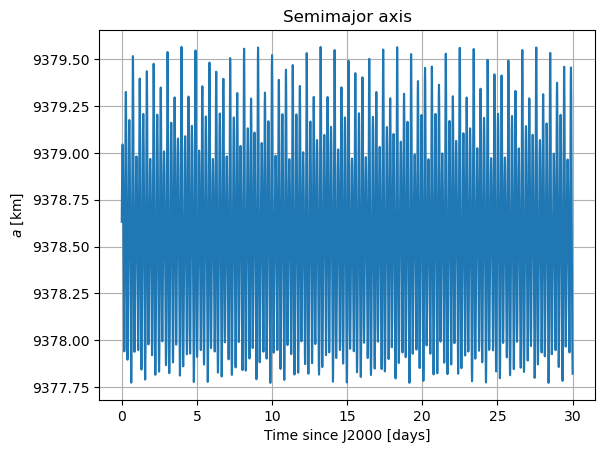

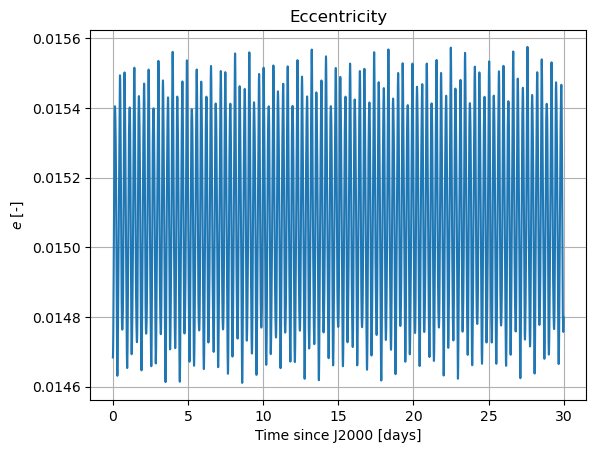

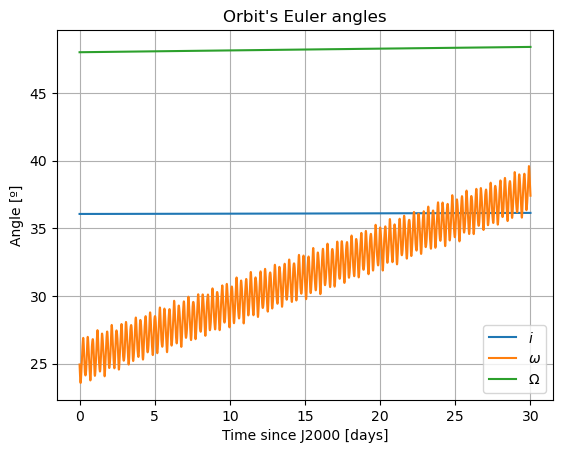

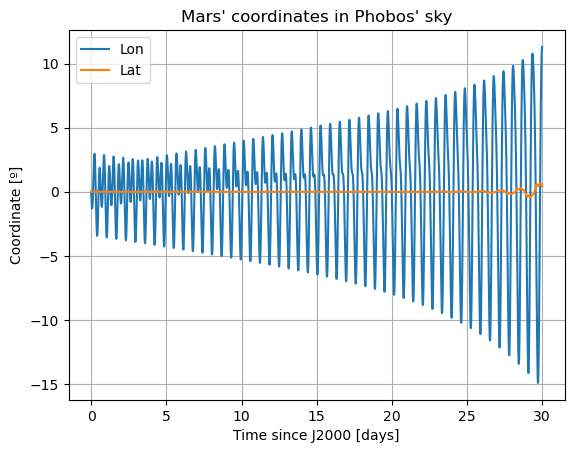

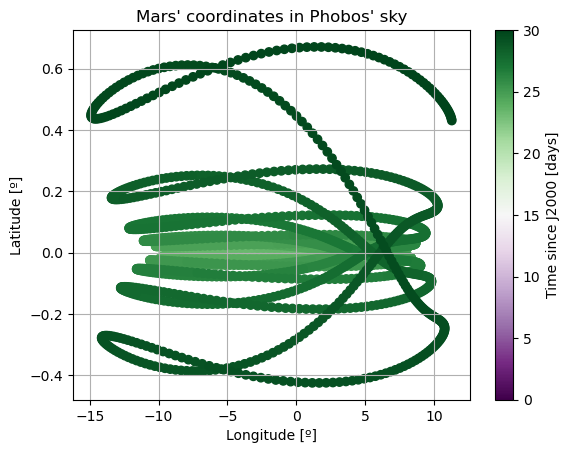

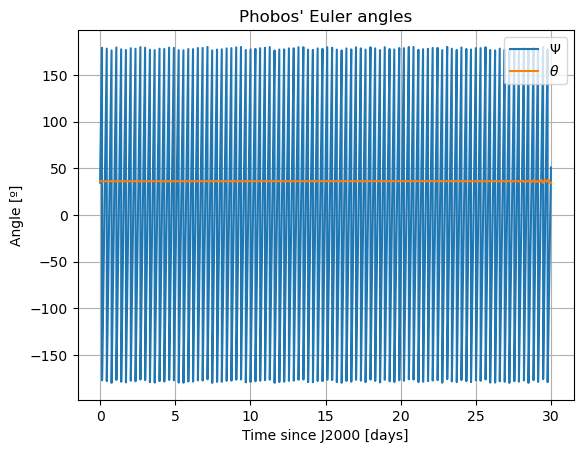

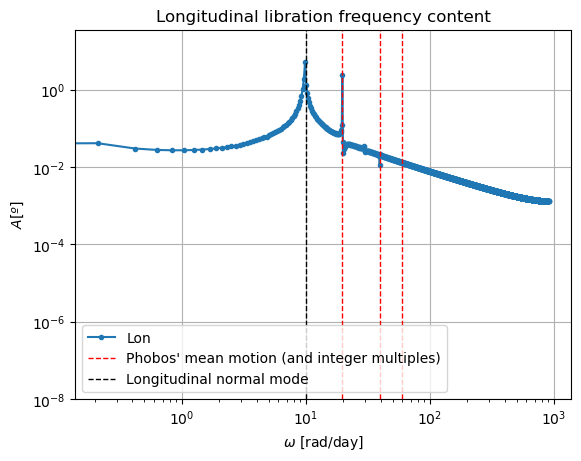

In [11]:
## PLOTS

# INDEX:      1,   2,   3,   4,     5,    6,     7,  8,   9,   10,     11,        12,        13
# STATE:      x,   y,   z,   vx,    vy,   vz,    q0, q1,  q2,  q3,     ang_vel_1, ang_vel_2, ang_vel_3
# DEPENDENTS: a,   e,   i,   omega, RAAN, theta, r,  lat, lon, euler3, euler1,    euler3

states_array = result2array(state_history)
dependents_array = result2array(dependent_variable_history)
epochs = states_array[:,0] / constants.JULIAN_DAY
time_label = 'Time since J2000 [days]'


plt.figure()
plt.plot(epochs, dependents_array[:,1] / 1e3)
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$a$ [km]')
plt.title('Semimajor axis')

plt.figure()
plt.plot(epochs, dependents_array[:,2])
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$e$ [-]')
plt.title('Eccentricity')

plt.figure()
plt.plot(epochs, np.degrees(dependents_array[:,3]), label = r'$i$')
plt.plot(epochs, np.degrees(dependents_array[:,4]), label = r'$\omega$')
plt.plot(epochs, np.degrees(dependents_array[:,5]), label = r'$\Omega$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Orbit\'s Euler angles')

plt.figure()
plt.plot(epochs, np.degrees(dependents_array[:,9]), label = r'Lon')
plt.plot(epochs, np.degrees(dependents_array[:,8]), label = r'Lat')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Coordinate [º]')
plt.title('Mars\' coordinates in Phobos\' sky')

cmap = plt.get_cmap('PRGn')
fig, axis = plt.subplots()
axis.scatter(np.degrees(dependents_array[:,9]), np.degrees(dependents_array[:,8]), c = epochs, cmap = cmap)
axis.grid()
axis.set_xlabel('Longitude [º]')
axis.set_ylabel('Latitude [º]')
axis.set_title('Mars\' coordinates in Phobos\' sky')
fig.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(epochs[0], epochs[-1])), ax=axis,
                 orientation='vertical', label=time_label)

plt.figure()
plt.plot(epochs, np.degrees(bring_inside_bounds(dependents_array[:,10], -PI, PI, include = 'upper')), label = r'$\Psi$')
plt.plot(epochs, np.degrees(dependents_array[:,11]), label = r'$\theta$')
# plt.plot(epochs, np.degrees(dependents_array[:,12]), label = r'$\varphi$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Phobos\' Euler angles')

mean_motion = 0.0002278563609852602
normal_mode = get_longitudinal_normal_mode_from_inertia_tensor(bodies.get('Phobos').inertia_tensor, mean_motion)
librations = bring_inside_bounds(dependents_array[:,8:10], -PI, PI, 'upper')
lon_lib_freq, lon_lib_amp = get_fourier(np.hstack((np.atleast_2d(dependents_array[:,0]).T, np.atleast_2d(librations[:,1]).T)), [TWOPI, 1])
lat_lib_freq, lat_lib_amp = get_fourier(np.hstack((np.atleast_2d(dependents_array[:,0]).T, np.atleast_2d(librations[:,0]).T)), [TWOPI, 1])
plt.figure()
plt.loglog(lon_lib_freq * 86400.0, np.degrees(lon_lib_amp), marker='.', label='Lon')
# plt.loglog(lat_lib_freq * 86400.0, np.degrees(lat_lib_amp), marker='.', label='Lat')
plt.gca().set_ylim(bottom=1e-8)
plt.axvline(mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0, label='Phobos\' mean motion (and integer multiples)')
plt.axvline(normal_mode * 86400.0, ls='dashed', c='k', linewidth = 1.0, label='Longitudinal normal mode')
plt.axvline(2 * mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0)
plt.axvline(3 * mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0)
plt.title('Longitudinal libration frequency content')
plt.xlabel(r'$\omega$ [rad/day]')
plt.ylabel(r'$A [º]$')
plt.grid()
plt.legend()

plt.show()

**Note:** The third Euler angle of Phobos, $\varphi$, has been commented out of the plot. This is because it represents Phobos' rotation about its $z$ axis, and therefore it will increase secularly and overlap with $\Psi$.

Here, there are two things that immediately stand out: Mars' coordinates in Phobos' sky are a mess (i.e. Phobos' orientation is not what we expected) and the inclination of Phobos is nowhere near 0. We will start by addressing the latter. Notice that "the inclination of Phobos" is usually thought of as measured from the Martian equator. Here, however, the Euler angles of the orbit are computed with respect to inertial space, i.e. the equator of the Earth in this case. The Martian equator is inclined by about $35.5º$ with respect to that of the Earth, and that is why we see Phobos' inclination oscillate around that value rather than $0º$.

Explaining the orientation of Phobos is a bit lengthier. The rotational equations of motion presented at the beginning of this example, also known as Euler equations, give rise to non-trivial oscillatory solutions when their homogeneous form are solved. This means that, even when setting all torques to 0, Phobos' rotational motion will be oscillatory around all three axes. These solutions are called _proper modes_ or _normal modes_ and have a particular frequency associated to them - which is often times referred to as _normal mode_ as well - which is determined by Phobos' physical properties and the mean motion of its orbit. Although an in-depth discussion of normal modes will not be provided here - the interested reader is referred to [reference to Appendix B of my literature study] for that - the two properties that one should know about them are:
* They **always** vanish in the presence of damping
* They **never** vanish in the absence of damping.

Phobos is not observed to contain any normal modes in its present day rotational motion. However, in the dynamics we have modelled in this example, damping does not exist and therefore the normal modes will naturally arise. This can be very well seen in the frequency content of the longitudinal libration. A similar plot is obtained for the Fourier transform of the Euler angles. Thus, this _undamped_ dynamics os not a realistic representation of Phobos' motion. Nevertheless, the presence of these normal modes do not affect Phobos' translation in a significant way: both the semi-major axis and eccentricity oscillate around a constant value in a similar way as they would in a purely translational simulation, and the orbit's Euler angles show the expected secularity in the arguments of periapsis (fast) and the nodes (slow).

In any case, a representative coupled simulation needs to eliminate the normal modes of these dynamics.

**Note:** If you are wondering why the FFT peak at the normal mode does not *exactly* coincide with the reference line, it is because this reference line has been computed with an approximate expression.

## Getting rid of the normal modes
As we just saw, Phobos does not quite spin the way we would expect it to due to the excitation of its normal modes. Two questions that may arise are (1) why we don't see the normal modes in real life and (2) how to we get rid of the normal modes in the simulation. The answer to both lies in **damping**. A mathematical discussion of how damping and external forcings affect normal modes is given in [reference to appendix B of my literature study]. Phobos has been spinning up there for about 4.5 thousands of millions of years (that is not a made up number). In that time, any little amount of damping that the body was subjected to - be it for structural reasons, or additional torques we are not considering - has been able to make the normal modes vanish, and that is why Phobos does not present these rotations anymore. This presents two complications in getting rid of normal modes in the simulation: we cannot really simulate all $4.5\times10^9$ years that Phobos has been orbiting Mars, and we don't really know if any of the torques that we have included in our rotational dynamics have a damping effect.

The solution to these problems is to introduce a _virtual torque_ ("virtual" is just the scientific word for "made up") that we know has a strong damping effect, and we propagate the dynamics forward. At one point, we will reach a state in which the normal modes have been eliminated. Now, we remove this damping torque and we propagate the dynamics backward for the same amount of time. This new rotational state that we have found, call it _damped initial state_ will not excite the normal modes of Phobos when propagated forward in the original dynamics, by definition, because that is how it was obtained. In practice, this can be done in several ways, and decisions are to be made with respect to, for instance, (a) how to compute this torque or (b) how long to propagate back and forth for. Moreover, the question still remains of what would happen if we apply this torque for, say, 1 year, and then try to use the new damped initial state to propagate a 2 year long arc. Would the normal modes still be removed after that 1 year. If not, how do they come back: suddenly or gradually? Answers to all these questions will not be covered here (it is not the point of this example), but the interested reader is referred to [reference to the appendix of my soon-to-exist master thesis] for an algorithm of the computation of the virtual damping torque.

Here, we will cover how to obtain the damped state in Tudat. In Tudat, the forward-backward propagation scheme is performed several times. A _damping time_ is selected, which is a measure of how quick the torque will eliminate the normal modes, and it is used to compute the torque. The propagation is performed forwards with the torque for 10 times the specified damping time, and backwards without it, and the new state is used in another iteration with a new and larger damping time. Luckily, Tudat provides a function that performs all the iterations for us. It is called `get_zero_proper_mode_rotational_state`. The implementation of this function has been somewhat particularized to bodies that rotate uniformly around their Z axis. Thus, the damping torque will act to prevent the excitation of the normal modes while preserving that uniform rotation. The function thus requires as inputs: (1) the `bodies` object, (2) the `propagatotupler_settings` object, (3) the mean rotational rate of the body around its Z axis, and (4) a list of dissipation times or damping times in order to compute the virtual torques for the different iteration. The code looks as below.

In [ ]:
phobos_mean_rotational_rate = 0.000228035245  # In rad/s
# As dissipation times, we will start with 4h and keep duplicating the damping time in each iteration. In the final iteration, a damping time of 4096h means a propagation time of 40960h, which is a bit over 4.5 years.
dissipation_times = list(np.array([4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0])*3600.0)  # In seconds. Here, we
damping_results = numerical_simulation.propagation.get_zero_proper_mode_rotational_state(bodies,
                                                                                         combined_propagator_settings,
                                                                                         phobos_mean_rotational_rate,
                                                                                         dissipation_times)
damped_state_history = damping_results.forward_backward_states[-1][1]
damped_dependent_variable_history = damping_results.forward_backward_dependent_variables[-1][1]

As you can see, we are using the `bodies` and the `propagator_settings` that we had already created earlier. The output of this function is this `damping_results` object. It contains quite a few things, the most important of which are: \
· **The damped initial state.** This state is of the same type and size as the one provided in the `propagator_settings`. In this case of the coupled dynamics, a 13-dimensional vector. \
· **The forward-backward states.** It is a list of tuples. Each tuple contains the results of one iteration. In each of these tuples, there are two dictionaries: one of them is the state history of the forward propagation, i.e. with the damping torque; the other is the state history of the backward propagation, i.e. without the torque. There is one more tuple than iterations. The tuple in index 0 contains the undamped states, i.e. the histories of the forward and backward states when no torque is applied. **Note:** In this tuple, the two dictionaries are in principle the same, becuase the dynamics of both propagations are identical. The small errors that might be encountered are fully integration errors. \
· **The forward-backward dependent variables.** It is the exact same thing as the forward-backward states, but with the dependent variables provided in the `propagator_settings`.

Notice that `dapming_results` already contains the propagated states of the "fully" damped dynamics, which means there is no need to repropagate them again with the obtained damped initial state. The damped trjectory is readily available to us, although it spans the 40960h of the final damping time. To aid in comparison with the undamped dynamics from above, we will only plot the first 30 days.

## Let's look at plots (again)
With the new damped states and dependent variables, we can perform the same kind of post-processing that we did earlier.

In [ ]:
## PLOTS

# INDEX:      1,   2,   3,   4,     5,    6,     7,  8,   9,   10,     11,        12,        13
# STATE:      x,   y,   z,   vx,    vy,   vz,    q0, q1,  q2,  q3,     ang_vel_1, ang_vel_2, ang_vel_3
# DEPENDENTS: a,   e,   i,   omega, RAAN, theta, r,  lat, lon, euler3, euler1,    euler3

epochs_of_first_30_days = [epoch for epoch in list(state_history.keys()) if epoch <= 30.0*constants.JULIAN_DAY]
reduced_history = dict.fromkeys(epochs_of_first_30_days)
for epoch in epochs_of_first_30_days:
    reduced_history[epoch] = damped_state_history[epoch]
damped_states_array = result2array(reduced_history)
for epoch in epochs_of_first_30_days:
    reduced_history[epoch] = damped_dependent_variable_history[epoch]
damped_dependents_array = result2array(reduced_history)
epochs = damped_states_array[:,0] / constants.JULIAN_DAY
time_label = 'Time since J2000 [days]'

plt.figure()
plt.plot(epochs, damped_dependents_array[:,1] / 1e3)
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$a$ [km]')
plt.title('Semimajor axis')

plt.figure()
plt.plot(epochs, damped_dependents_array[:,2])
plt.grid()
plt.xlabel(time_label)
plt.ylabel(r'$e$ [-]')
plt.title('Eccentricity')

plt.figure()
plt.plot(epochs, np.degrees(damped_dependents_array[:,3]), label = r'$i$')
plt.plot(epochs, np.degrees(damped_dependents_array[:,4]), label = r'$\omega$')
plt.plot(epochs, np.degrees(damped_dependents_array[:,5]), label = r'$\Omega$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Orbit\'s Euler angles')

plt.figure()
plt.plot(epochs, np.degrees(damped_dependents_array[:,9]), label = r'Lon')
plt.plot(epochs, np.degrees(damped_dependents_array[:,8]), label = r'Lat')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Coordinate [º]')
plt.title('Mars\' coordinates in Phobos\' sky')

cmap = plt.get_cmap('PRGn')
fig, axis = plt.subplots()
axis.scatter(np.degrees(damped_dependents_array[:,9]), np.degrees(damped_dependents_array[:,8]), c = epochs, cmap = cmap)
axis.grid()
axis.set_xlabel('Longitude [º]')
axis.set_ylabel('Latitude [º]')
axis.set_title('Mars\' coordinates in Phobos\' sky')
fig.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(epochs[0], epochs[-1])), ax=axis,
                 orientation='vertical', label=time_label)

plt.figure()
plt.plot(epochs, np.degrees(bring_inside_bounds(damped_dependents_array[:,10], -PI, PI, include = 'upper')), label = r'$\Psi$')
plt.plot(epochs, np.degrees(damped_dependents_array[:,11]), label = r'$\theta$')
# plt.plot(epochs, np.degrees(damped_dependents_array[:,12]), label = r'$\varphi$')
plt.grid()
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r'Angle [º]')
plt.title('Phobos\' Euler angles')

mean_motion = 0.0002278563609852602
normal_mode = get_longitudinal_normal_mode_from_inertia_tensor(bodies.get('Phobos').inertia_tensor, mean_motion)
damped_librations = bring_inside_bounds(damped_dependents_array[:,8:10], -PI, PI, 'upper')
damped_lon_lib_freq, damped_lon_lib_amp = get_fourier(np.hstack((np.atleast_2d(damped_dependents_array[:,0]).T, np.atleast_2d(damped_librations[:,1]).T)), [TWOPI, 1])
damped_lat_lib_freq, damped_lat_lib_amp = get_fourier(np.hstack((np.atleast_2d(damped_dependents_array[:,0]).T, np.atleast_2d(damped_librations[:,0]).T)), [TWOPI, 1])
plt.figure()
plt.loglog(damped_lon_lib_freq * 86400.0, np.degrees(damped_lon_lib_amp), marker='.', label='Lon')
# plt.loglog(lat_lib_freq * 86400.0, np.degrees(lat_lib_amp), marker='.', label='Lat')
plt.gca().set_ylim(bottom=1e-8)
plt.axvline(mean_motion * 86400.0, ls='dashed', c='r', linewidth = 1.0, label='Phobos\' mean motion (and integer multiples)')
plt.axvline(normal_mode * 86400.0, ls='dashed', c='k', linewidth = 1.0, label='Longitudinal normal mode')
plt.axvline(2 * mean_motion * 86400.0, ls='dashed', linewidth = 1.0, c='r')
plt.axvline(3 * mean_motion * 86400.0, ls='dashed', linewidth = 1.0, c='r')
plt.title('Longitudinal libration frequency content')
plt.xlabel(r'$\omega$ [rad/day]')
plt.ylabel(r'$A [º]$')
plt.grid()
plt.legend()

plt.show()

In these new damped dynamics, Mars does oscillate periodically around $0º$ of latitude and longitude in Phobos' sky, and the Fourier transform shows that the frequency at the normal mode is gone. Note that we would see the same thing in the FFT of Phobos' Euler angles. This is now a faithful representation of Phobos' motion.